# Actividad 1 - Módulo 1 - Simulación de roombas

Este programa tiene la función de simular un cuarto donde se coloquen "roombas" o barredoras que se muevan a través del espacio y limpien toda suciedad que se encuentren. Se importan librerías que permiten el uso de "Multiagentes" (clases con un comportamiento específico para cumplir diferentes objetivos), uso de matrices y arreglos específicos, así como "Pandas" que permiten organizar la información del programa.

## Integrantes del equipo
* Luis Ángel Guzmán Iribe - A01741757
* Cesar Galvez - A01252177
* Antonio López Chávez - A01741741
* Sebastián Gálvez Trujillo - A01251884

## Profesores
* María Angélica Barreda Beltrán
* Jorge Mario Cruz Duarte

## Reglas

Las reglas de la simulación varían según el tipo de agente, siendo la clase "TileAgent" correspondiente a las celdas que rellenarán el "Grid" creado y la clase "RoombaAgent", las barredoras que limpiarán el espacio.

Características de celdas:
1. Existen valores predefinidos en el código (sección de "Ejecución del modelo") que dictan el tamaño del grid y por ende la cantidad de agentes de celdas que se crearán (Ancho * Altura = número de agentes).
2. Otros valores predefinidos permiten el cálculo de la cantidad de celdas sucias, se eligen aleatoriamente las coordenadas de estas celdas.

Reglas de celdas:
1. Solo habrá un agente de celda por cada coordenada del grid.
2. Solo puede tener un estado, sucia o limpia, cada uno con un color diferente.
3. La primer fila de celdas tiene la característica de cargar la batería de las barredoras.

Reglas de "roombas" o barredoras:
1. Tienen dos acciones, limpiar la celda donde se encuentran o moverse en una de sus posibles direcciones (todas sus celdas adyacentes).
2. Cada acción le toma un "step" o generación, es decir, no puede moverse y limpiar al mismo tiempo.
3. Cada generación reduce en "1" la batería del "roomba", ya sea que limpie o se mueva.
4. Su batería se recarga si pasan por una celda de la primera fila del "grid".
5. Al acabarse su batería, su estado pasa a "descargada", por lo que ya no puede moverse y gráficamente cambia de color.
6. Pueden convivir en la misma celda con otros "roombas", sin interferir en sus acciones.

## Diagramas de estado

* Celda
<center>
<img src="./Diagrama de estado - Celda Tile.png" width=auto height=auto />
</center>

* Roomba
<center>
<img src="./Diagrama de estado - Roomba barredora.png" width=auto height=auto />
</center>

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: versión 3.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [501]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model 

# 'MultiGrid' permite generar un "grid" que tenga la capacidad de tener más de un solo agente en una misma casilla
from mesa.space import MultiGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

from random import sample

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo

Este modelo se trata de una simulación de un espacio de MxN casillas o baldosas, las cuales según un porcentaje predefinido en el código, estarán sucias (color negro) o limpias (color blanco). Al iniciar el programa, un número predefinido de barredoras o "roombas" (color azul) se inician en la fila inicial, para luego moverse entre generaciones o pasos. 
Los "roombas" tienen dos acciones, limpiar la celda o moverse por el espacio, con cada acción durando una generación. El objetivo es calcular cuantos movimientos realizaron durante cada animación, el porcentaje de celdas limpias al terminar la animación y la duración de los movimientos (si se terminaron de limpiar las celdas, se les acabó la batería o llegaron al tiempo máximo).

In [502]:
class TileAgent(Agent):
    """
    Representa a un agente o una celda con estado sucio (1) o limpio (0)
    """
    def __init__(self, unique_id, dirt, model):
        """
        Crea un agente que según el estado de suciedad (parámetro "dirt") va a corresponder a una celda/baldosa limpia (dirt = 0) o sucia (dirt = 1)
        """
        super().__init__(unique_id, model)
        if dirt:
            self.dirty = 1
        else:
            self.dirty = 0

class RoombaAgent(Agent):
    """
    Esta clase corresponde al agente del "roomba" o barredora. Tiene sus métodos para sus acciones, dar un paso entre sus 8 posibles direcciones 
    o limpiar la celda donde se encuentra.
    """
    def __init__(self, unique_id, initial_charge, model):

        super().__init__(unique_id, model)
        self.battery = initial_charge
        self.initial_charge = initial_charge
        self.movements = 0
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False,
            )

        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position, )

        self.movements += 1

    def step(self):

        posX, posY  = self.pos

        if(posX == 0):
            self.battery = self.initial_charge

        if self.battery > 0:
            self.battery -= 1

            # Guarda en un arreglo a los agentes que se encuentran en la misma celda
            cellmates = self.model.grid.get_cell_list_contents([self.pos])

            #print(self.pos)
            for cellmate in cellmates:
                if(isinstance(cellmate, TileAgent)):
                    if(cellmate.dirty == 1):
                        # print(self.pos, cellmate.dirty)
                        cellmate.dirty = 0;
                    else:
                        self.move();


class CleaningRoomModel(Model):
    """
    Define el modelo de la habitación de limpieza
    """
    def __init__(self, width, height, num_roomba_agents, initial_charge, random):
        self.num_agents = width * height
        self.num_roomba_agents = num_roomba_agents
        self.grid = MultiGrid(width, height, False)
        self.schedule = SimultaneousActivation(self)
        """
        Crea los agentes 'Tiles'
        """
        # Genera una lista de coordenadas que serán determinadas como sucias y las guarda en el arreglo dirtListRandom
        dirtList = []
        for (content, x, y) in self.grid.coord_iter():
            dirtList.append([x,y])
        dirtListRandom = sample(dirtList, random)

        # Crea los agentes 'Tile'  y les asigna su estado de suciedad dependiendo el arreglo 'dirtListRandom'
        for (content, x, y) in self.grid.coord_iter():
            dirt = False

            # Si la coordenada está en el arreglo de celdas sucias, cambia el valor dirt a True para significar que esa celda está sucia 
            if [x,y] in dirtListRandom:
                dirt = True

            # Crea el agente 'Tile'
            a = TileAgent((x, y), dirt, self)
            self.grid.place_agent(a, (x, y))

        """
        Crea los agentes 'Roomba'
        """
        # Se generan los roombas en la primera fila, colocándose uno por uno en cada celda de la misma
        for i in range(num_roomba_agents):
            r = RoombaAgent(i, initial_charge, self)
            self.grid.place_agent(r, (0, i % height)) # El operador % permite ir asignando las posiciones en la primer fila, sin repetir siempre la misma celda
            self.schedule.add(r)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={
                "Grid": self.get_grid,
                "% Casillas limpias": self.get_clean_tiles
            },
            agent_reporters={
                "Movimientos": "movements"
            }
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla, manda los valores de suciedad o de barredora a la celda para su color designado
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            # Si detecta más de un agente en la misma celda, significa que hay una barredora y debe predominar su color en la celda
            if len(cell_content) > 1:
                grid[x][y] = 3 if cell_content[1].battery > 0 else 2
            else:
                grid[x][y] = cell_content[0].dirty
                
        # Regresa el grid con cada celda teniendo un valor para su coloreado. 0 = blanco, 1 = negro, 2 = azul
        return grid

    def get_clean_tiles(self):

        clean_tiles = 0

        for cell_content, x, y in self.grid.coord_iter():
            if cell_content[0].dirty == 0:
                clean_tiles += 1

        return clean_tiles/self.num_agents

# Ejecución del modelo
A continuación corremos el modelo, asignando valores de anchura, altura, generaciones, número de agentes, etc.

In [503]:
# Definimos el ancho del Grid
GRID_WIDTH = 6

# Definimos la altura del Grid
GRID_HEIGHT = 6

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 50

# Definimos el porcentaje de celdas sucias al comenzar la simulación (valor decimal)
DIRT_PRCNTG = 0.60

# Definimos el número de agentes
NUM_AGENTS = 3

# Carga inicial de los agentes Roomba
INITIAL_CHARGE = 20

# Tiempo máximo para la ejecución (segundos y decimales de segundo [00.000000])
MAX_TIME = 0.010

# Obtener el número exacto de celdas sucias, usando el tamaño del grid y su porcentaje de suciedad
random = int((GRID_HEIGHT * GRID_WIDTH) * DIRT_PRCNTG)

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()
model = CleaningRoomModel(GRID_WIDTH, GRID_HEIGHT, NUM_AGENTS, INITIAL_CHARGE, random)

NUM_GEN_AUX = 0
for i in range(NUM_GENERATIONS):
        timeVar = str(datetime.timedelta(seconds=(time.time() - start_time)))
        timeVarUp = slice(5,len(timeVar))
        timeVarCurrent = float(timeVar[timeVarUp])
        if (timeVarCurrent <= MAX_TIME):
                NUM_GEN_AUX += 1
                model.step()

print('Generaciones recorridas:', NUM_GEN_AUX)

# Imprimimos el tiempo que le tomó correr al modelo y el tiempo máximo establecido.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print('Tiempo máximo de ejecución:', MAX_TIME, 'Segundos')

Generaciones recorridas: 50
Tiempo de ejecución: 0:00:00.005422
Tiempo máximo de ejecución: 0.01 Segundos


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información. Esta información se utiliza para la graficación/animación posterior.

In [504]:
all_grid = model.datacollector.get_model_vars_dataframe().loc[:,["Grid"]]
clean_tiles_percentage = model.datacollector.get_model_vars_dataframe().loc[:,["% Casillas limpias"]]

gens_to_complete_cleaning = 0

for gen in clean_tiles_percentage["% Casillas limpias"]:
    gens_to_complete_cleaning += 1
    if(gen == 1):
        break

roomba_movements = model.datacollector.get_agent_vars_dataframe()
total_roomba_movements = 0

# Revisa los últimos 'NUM_AGENTS' valores de la columna 'Movimientos' del dataframe 'roomba_movements' y los suma a la variable 'total_roomba_movements'
for i in range(NUM_AGENTS):
    total_roomba_movements += roomba_movements["Movimientos"].iat[-i-1]



Información del Modelo

Generaciones que tardó en limpiar toda la habitación: No se terminó de limpiar (50 generaciones)
* Se necesitan más generaciones *
Porcentaje de celdas limpias después del termino de la simulación:  80.55555555555556 %
Número de movimientos realizados por todos los agentes:  91


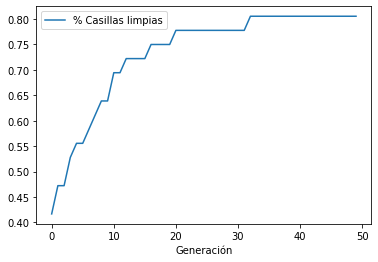

In [505]:
clean_tiles_plt = clean_tiles_percentage[clean_tiles_percentage["% Casillas limpias"] < 1].plot()
clean_tiles_plt.set_xlabel("Generación")
if(clean_tiles_percentage["% Casillas limpias"].iat[-1]*100 < 100.0):
    print("Generaciones que tardó en limpiar toda la habitación: No se terminó de limpiar (" + str(NUM_GENERATIONS), "generaciones)")
    if (NUM_GEN_AUX != NUM_GENERATIONS):
        print("* Se excedió el tiempo de ejecución (límite de", MAX_TIME, "segundos) *")
    else:
        print("* Se necesitan más generaciones *")
else:
    print("Generaciones que tardó en limpiar toda la habitación: ", gens_to_complete_cleaning)
print("Porcentaje de celdas limpias después del termino de la simulación: ", clean_tiles_percentage["% Casillas limpias"].iat[-1]*100, "%")
print("Número de movimientos realizados por todos los agentes: ", total_roomba_movements)


Graficamos la información usando `matplotlib`

In [506]:
%%capture
fig, axs = plt.subplots(figsize=(8,8))
axs.set_xticks([])
axs.set_yticks([])
cmap = matplotlib.cm.get_cmap('viridis', 4) # Puede ser cualquier otra
cmap = cmap(np.linspace(0, 1, 4))
cmap[0] = np.array([256/256, 256/256, 256/256, 1]) # Tile limpia
cmap[1] = np.array([0/256, 0/256, 0/256, 1]) # Tile sucia
cmap[2] = np.array([0/256, 50/256, 100/256, 1]) # Roomba con batería
cmap[3] = np.array([0/256, 50/256, 200/256, 1]) # Roomba sin batería

new_cmap = matplotlib.colors.ListedColormap(cmap)
patch = plt.imshow(all_grid.iloc[0][0], cmap=new_cmap)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=NUM_GEN_AUX)

In [507]:
anim


Notas: 
* Aquellos "Roombas" que al terminar la animación, no hayan cambiado de color, terminan así porque se acabó el número de generaciones o se llegó al tiempo máximo de ejecución y no se les acabó la batería. Solo cambian de color si la batería se agota. 
* Si se da la impresión de que algún "Roomba" desapareció, es porque se encimaron dos o más de estos agentes.

## Análisis de resultados
Las variables que más afectan al porcentaje de limpieza son todas aquellas directamente relacionadas con el agente "Roomba", mientras más batería tengan, mayores casillas pueden limpiar, lo mismo sucede cuando se agregan más de estos agentes al espacio. Estas dos variables iniciales son bastante dependientes entre sí, pues una sola barredora puede limpiar bastante con mucha batería, pero la aleatoriedad de sus movimientos hace que no siempre pueda llegar a todas las casillas sucias. En el caso contrario, si hay muchas barredoras, pero con poca batería, pueden esparcirse mucho hasta acabarse la batería, sacrificando barredoras en el camino, pero seguirán sin garantizar una limpieza total. Al final de cuentas, los resultados casi nunca se repiten, pues está hecho de manera que no se pueden predecir los movimientos. 
Otro detalle importante es que el agregar una forma de recargar la batería hace que sea más probable que se limpien las primeras filas, pues muchas barredoras se quedan en ese espacio y terminan de limpiarlas. Esto también propicia que no siempre el tener una cantidad de movimientos elevada significa que se limpiaron muchas casillas, la mayoría pueden ser estas barredoras que no se terminan de descargar y solo se mueven por espacios ya limpios.

## Conclusiones
Esta es una actividad de introducción al mundo de los multiagentes, lo cual a su vez introduce a las inteligencias artificiales. Cuando ves el código del Juego de la Vida se ve como algo bastante complicado y extraño, pero una vez que se analizó con la ayuda del profesor y en el equipo de trabajo, se puede apreciar como es algo realmente intuitivo, es por eso que se pudo completar la programación de esta actividad, pues se supo hace "ingeniería inversa" para entender y aplicar la lógica, funciones y recolección de datos que requiere la tarea. El tema es bastante interesante y aun hay mucho que explorar.